In [22]:
import os
import shutil
import random
import torch
import torchvision
import numpy as np
import cv2 as cv
from PIL import Image
from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)
import torchvision.transforms as transforms
import io

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.7.1+cpu


In [23]:
class_names = ['correct_mask', 'incorrect_mask', 'no_mask']
root_dir = 'C:/Users/Ibrahim/dataset/train/'
source_dirs = ['Correct Mask', 'Incorrect Mask', 'No Mask']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) ]
        selected_images = random.sample(images, 111)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [24]:
class facemaskclass(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) ]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['Correct Mask', 'Incorrect Mask', 'Without Mask']
            
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [25]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224,0.225])
])

In [26]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224,0.225])
])

In [27]:
train_dirs = {
    'Correct Mask': 'C:/Users/Ibrahim/dataset/train/correct_mask',
    'Incorrect Mask': 'C:/Users/Ibrahim/dataset/train/incorrect_mask',
    'Without Mask': 'C:/Users/Ibrahim/dataset/train/no_mask'
}
train_dataset = facemaskclass(train_dirs, train_transform)

Found 4620 Correct Mask examples
Found 4575 Incorrect Mask examples
Found 4788 Without Mask examples


In [28]:

test_dirs = {
    'Correct Mask': 'C:/Users/Ibrahim/dataset/train/test/correct_mask',
    'Incorrect Mask': 'C:/Users/Ibrahim/dataset/train/test/incorrect_mask',
    'Without Mask': 'C:/Users/Ibrahim/dataset/train/test/no_mask'
}
test_dataset = facemaskclass(test_dirs, test_transform)

Found 111 Correct Mask examples
Found 111 Incorrect Mask examples
Found 111 Without Mask examples


In [29]:
batch_size = 5

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                      shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                     shuffle=True)

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))

Num of training batches 2797
Num of test batches 67


In [30]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(12,12))
    for i, image in enumerate(images):
        plt.subplot(1, 5, i +1, xticks=[], yticks=[])
        image = image.numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

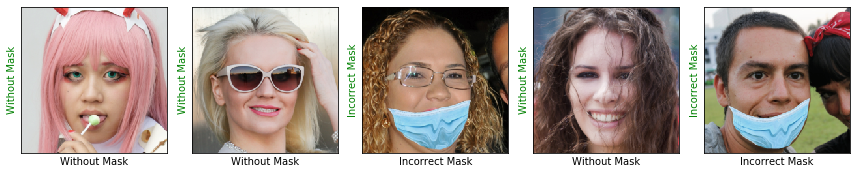

In [31]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

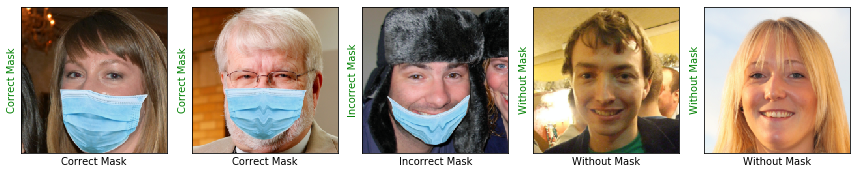

In [32]:

images, labels = next(iter(dl_test))
show_images(images, labels, labels)

In [33]:

resnet18 = torchvision.models.resnet50(pretrained=True)
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\Ibrahim/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

)


In [40]:

resnet18.fc = torch.nn.Linear(in_features=2048, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [41]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

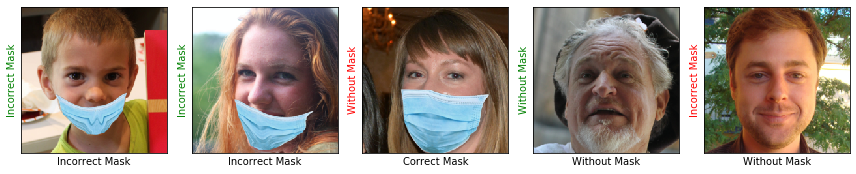

In [42]:
show_preds()


In [43]:
def train(epochs):
    print('Starting training..')
    for e in range(epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        
        resnet18.train()
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
           # images, labels = images.to(device), labels.to(device)
            
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                acc = 0
                val_loss = 0
                resnet18.eval()
            
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss +=loss.item()
                
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                val_loss /= (val_step +1)
                acc = acc / len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                  
                resnet18.train()
                  
                if acc > 0.95:
                    print('Performance condition satisfied')
  
                    break
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:.4f}')
    e=e+1
    if e>3:
      return        

Starting training..
Starting epoch 1/3
Evaluating at step 0
Val loss: 1.0755, Acc: 0.3964


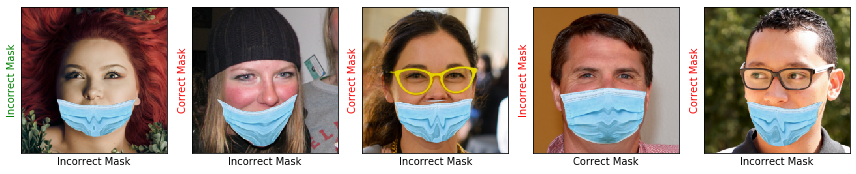

Evaluating at step 20
Val loss: 0.5556, Acc: 0.8799


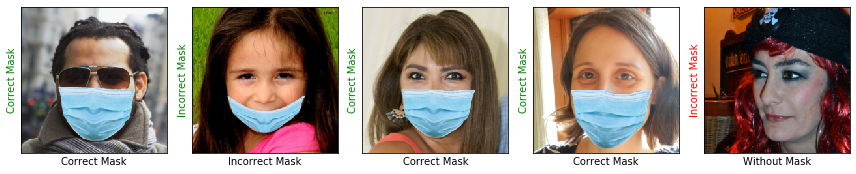

Evaluating at step 40
Val loss: 0.1962, Acc: 0.9700


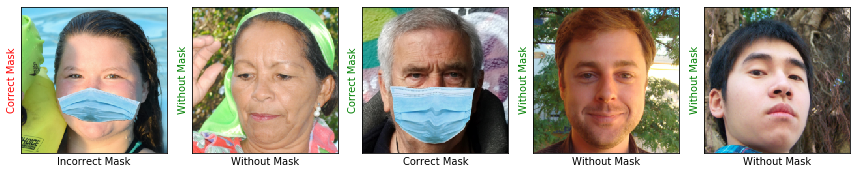

Performance condition satisfied
Training loss: 0.7565
Starting epoch 2/3
Evaluating at step 0
Val loss: 0.1922, Acc: 0.9640


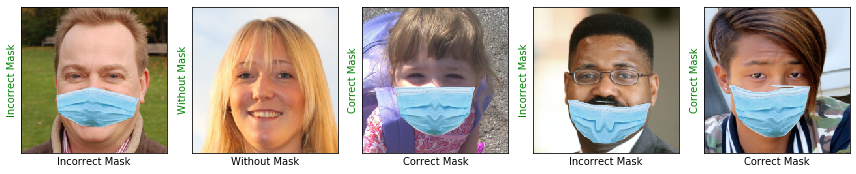

Performance condition satisfied
Training loss: 0.3275
Starting epoch 3/3
Evaluating at step 0
Val loss: 0.1660, Acc: 0.9730


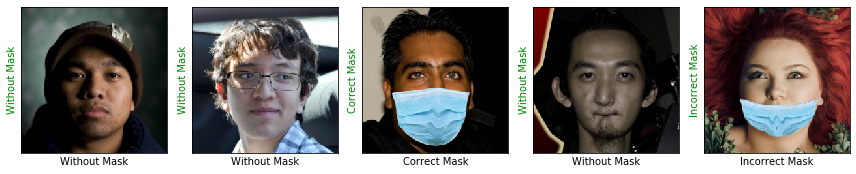

Performance condition satisfied
Training loss: 0.4658


In [44]:
hist=train(epochs=3)


In [45]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)
   

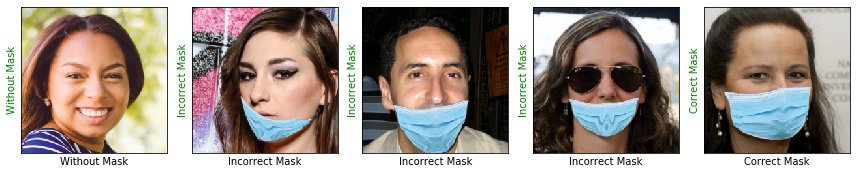

In [46]:
show_preds()


In [47]:
model=resnet18

In [48]:

torch.save(model.state_dict(),"C:/Users/Ibrahim/dataset/model.pth")

In [49]:
from facenet_pytorch import MTCNN
import cv2 as cv
from PIL import Image
import torch
from math import ceil as r 
import torchvision.models as models
import torch.nn as nn
#Importing modules



In [50]:
state_dict = torch.load('C:/Users/Ibrahim/dataset/model.pth')
#loading the state_dict to the model
model=models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)
model.load_state_dict(state_dict)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [51]:
#Importing libraries
from facenet_pytorch import MTCNN
import cv2 as cv
from PIL import Image
import torch
from math import ceil as r 

#Importing modules
from CNN import ResNet15, ResNet9
from DataPreprocessing import Preprocessing

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#model

#model = ResNet15(1,2)


#the classifier
mtcnn = MTCNN(select_largest=False, device=device)

# Load a single image and display
cap = cv.VideoCapture(0)

labels = {
    0:'with mask',
    1:'without mask',
    2:'no mask'
   
    }
color_dict={
    0:(255,0,255),
    1:(255,0,0),
    2:(255,255,0)
    }

def resize(frame, height, width):
    '''
    This function will resize the image 
    if the frame is above a certain condition
    '''
    if height and width >= 1000:
        return cv.resize(frame, (r(height*0.5), r(width*0.5)))
    elif height and width >= 2500:
        return cv.resize(frame, (r(height*0.7), r(width*0.7)))
    else:
        return cv.resize(frame, (height, width))

while True:
    success, frame = cap.read()
    
    if success:
        width, height, _ = frame.shape
        # if the video is too big uncomment the below code
        #frame = resize(frame, height, width)
        
        #padding the image to avoid the bounding going out of the image
        #and crashes the program
        padding =  cv.copyMakeBorder(frame, 50,50,50,50, cv.BORDER_CONSTANT)
        #converting numpy array into image
        image = Image.fromarray(padding)
        
        #gives the face co-ordinates
        face_coord,_ = mtcnn.detect(image)
        
        
        if face_coord is not None:
            for coord in face_coord:
                for x1,y1,x2,y2 in [coord]:
                    x1,y1,x2,y2 = r(x1),r(y1),r(x2),r(y2)
                    
                    #face array
                    face = padding[y1:y2 ,x1:x2]
                    
                    #Preprocessing
                    preprocess = Preprocessing(img=Image.fromarray(face))
                    #tensor array
                    image=Image.fromarray(face)
                    tensor_img_array = preprocess.preprocessed_arrays()
                    
                    #tensor_img_array.unsqueeze_(0)

                    #Predicting
                    #outputs = model(tensor_img_array)
                    # max returns (value ,index)
                    #_, label = torch.max(outputs,1)
                    prob, label = torch.max(torch.exp(model(
                                            tensor_img_array.to(device))),dim=1)
                    
                    print(label.item())
                    scale = round((y2-y1)*35/100)
                    #mini box
                    cv.rectangle(frame, (x1-50,y1-50), (x1-40,y1-40), 
                                                    color_dict[label.item()],-1)

                    #Bounding box
                    cv.rectangle(frame, (x1-50,y1-50), (x2-50,y2-50), 
                                                    color_dict[label.item()],1)
            
                    cv.putText(frame,labels[label.item()], 
                                (x1-50,y1-53),cv.FONT_HERSHEY_SIMPLEX,
                                                        scale*0.01,(255,255,0),1)
                    
        cv.imshow("Frame", frame)
        # im = Image.fromarray(frame)
        # im.save('mask/a%s.png'%(a))
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

         
    else:
        print('End')
        break
    
cap.release()
cv.destroyAllWindows()



2
2
2
2
2
2
2
2
2
2
2
2


In [11]:
import torchvision.transforms as transforms
import io


def transform_image(image):
    transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    #image = Image.open(image_bytes).convert('RGB')
    image = Image.open(image).convert('RGB')
    return transform(image).unsqueeze(0)


In [19]:
import cv2
#file=file=request.FILES[('C:/Users/Ibrahim/Pictures/Camera Roll/1.jpg')]
img_bytes = cv2.imread('C:/Users/Ibrahim/Pictures/Camera Roll/1.jpg',1)
image = Image.open(io.BytesIO(img_bytes)).convert('RGB')
tensor = transform_image(image)

OSError: cannot identify image file <_io.BytesIO object at 0x000002E7729D2BF8>